# Graph Representation Learning

In this notebook we will:

- Draw a metro map using graph embeddings
- Classify ML papers by different topics using citations graph
- Build Node2Vec embeddings
- Train Neighborhood Autoencoder

This notebook in Colab: [link](https://colab.research.google.com/drive/1xa9qkZlOZA2aZaioqSgyBatlTADG90IT?usp=sharing)

## Setup

In [1]:
!pip -qq install node2vec

In [2]:
from node2vec import Node2Vec
import networkx as nx
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

## Toy example with Moscow Metro

We will start with a Moscow Metro scheme, which can be interpreted as a graph. The stations are the nodes, while connections between them are the edges.

![](https://i.pinimg.com/originals/65/e1/03/65e1030f788ca888e7078f44a4a17c5e.png)

Define graph's nodes and edges.

In [3]:
red = ['Park Kultury Red', 'Kropotkinskaya', 'Biblioteka Lenina', 'Okhotny Ryad',
       'Lubyanka', 'Chistye Prudy', 'Krasnye Vorota', 'Komsomolskaya Red']
orange = ['Oktyabrskaya Orange', 'Tretyakovskaya Orange', 'Kitay Gorod Orange',
          'Turgenevskaya', 'Sukharevskaya', 'Prospekt Mira Orange']
grey = ['Serpukhovskaya', 'Polyanka', 'Borovitskaya', 'Chekhovskaya',
        'Tsvetnoy Bulvar', 'Mendeleevskaya']
green = ['Paveletskaya Green', 'Novokuznetskaya', 'Teatralnaya',
         'Tverskaya', 'Mayakovskaya', 'Belorusskaya Green']
purple = ['Taganskaya Purple', 'Kitay Gorod Purple', 'Kuznetskiy Most',
          'Pushkinskaya', 'Barrikadnaya']
blue = ['Kurskaya Blue', 'Ploschad Revolutsii', 'Arbatskaya Blue',
        'Smolenskaya', 'Kievskaya Blue']
circle = ['Park Kultury Circle', 'Oktyabrskaya Circle', 'Dobryninskaya', 'Paveletskaya Circle',
          'Taganskaya Circle', 'Kurskaya Circle', 'Komsomolskaya Circle', 'Prospekt Mira Circle',
          'Novoslobodskaya', 'Belorusskaya Circle', 'Krasnopresnenskaya', 'Kievskaya Circle']

In [4]:
lines = [red, orange, grey, green, purple, blue, circle]
graph = nx.Graph()

for line in lines:
    graph.add_node(line[0])
    for i in range(len(line) - 1):
        graph.add_node(line[i + 1])
        graph.add_edge(line[i], line[i + 1])

graph.add_edge(circle[0], circle[-1])

In [5]:
graph.add_edge('Park Kultury Red', 'Park Kultury Circle')
graph.add_edge('Oktyabrskaya Orange', 'Oktyabrskaya Circle')
graph.add_edge('Serpukhovskaya', 'Dobryninskaya')
graph.add_edge('Paveletskaya Green', 'Paveletskaya Circle')
graph.add_edge('Taganskaya Purple', 'Taganskaya Circle')
graph.add_edge('Kurskaya Blue', 'Kurskaya Circle')
graph.add_edge('Komsomolskaya Red', 'Komsomolskaya Circle')
graph.add_edge('Prospekt Mira Orange', 'Prospekt Mira Circle')
graph.add_edge('Mendeleevskaya', 'Novoslobodskaya')
graph.add_edge('Belorusskaya Green', 'Belorusskaya Circle')
graph.add_edge('Barrikadnaya', 'Krasnopresnenskaya')
graph.add_edge('Kievskaya Blue', 'Kievskaya Circle')

graph.add_edge('Chistye Prudy', 'Turgenevskaya')
graph.add_edge('Lubyanka', 'Kuznetskiy Most')
graph.add_edge('Okhotny Ryad', 'Teatralnaya')
graph.add_edge('Ploschad Revolutsii', 'Teatralnaya')
graph.add_edge('Chekhovskaya', 'Pushkinskaya')
graph.add_edge('Chekhovskaya', 'Tverskaya')
graph.add_edge('Pushkinskaya', 'Tverskaya')
graph.add_edge('Kitay Gorod Orange', 'Kitay Gorod Purple')
graph.add_edge('Tretyakovskaya Orange', 'Novokuznetskaya')
graph.add_edge('Biblioteka Lenina', 'Borovitskaya')
graph.add_edge('Biblioteka Lenina', 'Arbatskaya Blue')
graph.add_edge('Borovitskaya', 'Arbatskaya Blue')

Generate Node2Vec graph embeddings.

In [6]:
node2vec = Node2Vec(
    graph, dimensions=8, num_walks=100,
    walk_length=10, seed=103, p=2, q=1
).fit()

Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 51.36it/s]


Plot the Metro map using TSNE of embeddings.

In [7]:
embeddings = np.array([node2vec.wv[station] for station in sorted(graph.nodes)])
embeddings = TSNE(
    n_components=2, random_state=102,
    learning_rate='auto', init='random'
).fit_transform(embeddings)
mapping = dict(zip(sorted(graph.nodes), embeddings))

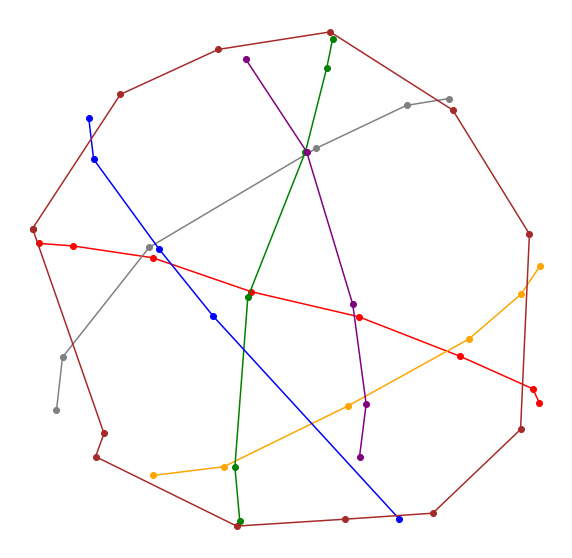

In [8]:
colors = ['red', 'orange', 'grey', 'green', 'purple', 'blue', 'brown']
plt.figure(figsize=(10, 10))
np.random.seed(100)

for i, line in enumerate(lines):
    vectors = np.zeros((len(line), 2))
    for j, station in enumerate(line):
        vectors[j] = mapping[station]
    if colors[i] == 'brown':
        vectors = np.concatenate((vectors, vectors[0].reshape(1, 2)))
    plt.plot(vectors[:, 0], vectors[:, 1], color=colors[i], marker='o')

plt.axis('off')
plt.grid(False)
plt.show()

We can also see transition probablities, which are approximated with the embeddings.

In [9]:
base = 'Tverskaya'
dot_products = dict()
for line in lines:
    for station in line:
        dot_products[station] = node2vec.wv[base] @ node2vec.wv[station]

norm = np.exp(np.array(list(dot_products.values()))).sum()
probabilities = dict(
    zip(sorted(dot_products.keys()),
    [np.exp(dot_products[station]) / norm \
    for station in sorted(dot_products.keys())])
)
probabilities = sorted(probabilities.items(), key=lambda item: -item[1])
probabilities[:10]

[('Mayakovskaya', 0.12688349),
 ('Belorusskaya Green', 0.09666803),
 ('Tverskaya', 0.08740857),
 ('Pushkinskaya', 0.054814555),
 ('Chekhovskaya', 0.05480498),
 ('Tsvetnoy Bulvar', 0.046519343),
 ('Belorusskaya Circle', 0.035725817),
 ('Teatralnaya', 0.029816365),
 ('Barrikadnaya', 0.027510175),
 ('Mendeleevskaya', 0.025974909)]

## Download and preprocess data

Now we will move forward to real data. The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words: [link](https://relational.fit.cvut.cz/dataset/CORA).

In [10]:
%%bash
wget -q https://web.archive.org/web/20151007064508/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz -O cora.tgz
tar -xf cora.tgz

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [12]:
content = pd.read_csv('cora/cora.content', sep='\t', header=None)
content = content.rename(columns={0: 'Id', 1434: 'target'}, errors="raise")
content = content.set_index('Id')
cites = pd.read_csv('cora/cora.cites', sep='\t', header=None)

In [13]:
content

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


In [14]:
cites

,0,1
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


In [15]:
X = content.drop(columns=['target']).to_numpy()
y = content['target'].to_numpy()
index = content.index.to_numpy()
y = LabelEncoder().fit_transform(y)

Now we can split our data to train and test.

In [16]:
X_train, X_test, y_train, y_test, train_index, test_index = \
    train_test_split(X, y, index, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((2031, 1433), (677, 1433))

## Baseline: Logistic Regression

We start our experiments with a baseline &mdash; Logistic Regression with the initial features of publications.

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [18]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1
).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished


In [19]:
print('Init features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(X_train)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(X_test)):.4f}')

Init features + Logistic Regression
Train accuracy: 0.9798
Test accuracy: 0.7563


We can see that our model overfits pretty much. This occurs because we have quite many features. We can try to reduce the features dimensionality using PCA to decrease overfitting.

## Dimensionality reduction with PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=256).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [22]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1
).fit(X_train_pca, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


In [23]:
print('PCA features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(X_train_pca)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(X_test_pca)):.4f}')

PCA features + Logistic Regression
Train accuracy: 0.9030
Test accuracy: 0.7415


We tangibly decreased overfitting with an accuracy drop of $1\%$. We will add this compressed features to graph embeddings to train better models at the next steps.

## Node2Vec

Now, we try to build embeddings of publications based on the citations graph structure. Here we use an undirected version of this graph.

In [24]:
graph = nx.Graph()
for node in index:
    graph.add_node(node)

for i, row in cites.iterrows():
    graph.add_edge(row[0], row[1])

In [25]:
node2vec = Node2Vec(graph).fit()

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


In [26]:
train_embeds = np.array([node2vec.wv[str(node)] for node in train_index])
test_embeds = np.array([node2vec.wv[str(node)] for node in test_index])
train_embeds.shape, test_embeds.shape

((2031, 128), (677, 128))

Test Node2Vec embeddings + Logistic Regression.

In [27]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(train_embeds, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished


In [28]:
print('Node2Vec embeddings + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(train_embeds)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(test_embeds)):.4f}')

Node2Vec embeddings + Logistic Regression
Train accuracy: 0.8464
Test accuracy: 0.8109


Now, try to combine Node2Vec embeddings with the PCA compression of the initial features.

In [29]:
n2v_train = np.concatenate([X_train_pca, train_embeds], axis=1)
n2v_test = np.concatenate([X_test_pca, test_embeds], axis=1)

In [30]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(n2v_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


In [31]:
print('Node2Vec embeddings + PCA features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(n2v_train)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(n2v_test)):.4f}')

Node2Vec embeddings + PCA features + Logistic Regression
Train accuracy: 0.9444
Test accuracy: 0.8730


## Neighborhood autoencoder

Here we will take the following similarity function ($d(v_i, v_j)$ is a length of the shortest path between $v_i$ and $v_j$ in the graph, $\tau > 0$ is some positive parameter):

$$
s_{\mathcal{G}}(v_i, v_j) = \exp\left(-\frac{d(v_i, v_j)}{\tau}\right)
$$

This proximity measure has several useful properties. First of all, $s_{\mathcal{G}}(v_i, v_j) = 1$, as $d(v_i, v_j)=0$. Also, if $v_j$ if not reachable from $v_i$, then formally $d(v_i, v_j)=\infty$ and $s_{\mathcal{G}}(v_i, v_j) = 0$. As $d(v_i, v_j) \ge 0$, then $0 \le s_{\mathcal{G}}(v_i, v_j) \le 1$.

First of all, we need to calculate pairwise distances. Here we use an undirected version of the graph, otherwise the distance matrix would be too sparse.

In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [33]:
graph = nx.Graph()
for node in index:
    graph.add_node(node)

for i, row in cites.iterrows():
    graph.add_edge(row[0], row[1])

In [34]:
distances = nx.all_pairs_shortest_path_length(graph)
id_to_index = {id: i for i, id in enumerate(index)}

In [35]:
distance_matrix = torch.zeros((X.shape[0], X.shape[0]))
tau = 5.
for node_id, dists in tqdm(distances, total=X.shape[0]):
    i = id_to_index[node_id]
    for neighbor_id, dist in dists.items():
        j = id_to_index[neighbor_id]
        distance_matrix[i, j] = np.exp(-dist / tau)

  0%|          | 0/2708 [00:00<?, ?it/s]

In [37]:
dataset = TensorDataset(distance_matrix)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Now, define a fully-connected architecture for the autoencoder. We will use 3 layers with the following dimensions:

$$
2708 \to 512 \to 256 \to 128
$$

In [36]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        assert len(dims) >= 2
        self.encoder = []
        self.decoder = []

        for i in range(len(dims) - 1):
            self.encoder.append(nn.Linear(dims[i], dims[i + 1]))

            if i != len(dims) - 2:
                self.encoder.append(nn.LeakyReLU(0.2))

        for i in range(len(dims) - 1, 0, -1):
            self.decoder.append(nn.Linear(dims[i], dims[i - 1]))

            if i != 1:
                self.decoder.append(nn.LeakyReLU(0.2))
        self.decoder.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
  
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

To obtain the embeddings, we train our autoencoder with a standard MSE loss.

In [50]:
autoencoder = AutoEncoder([distance_matrix.shape[0], 1024, 512])
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

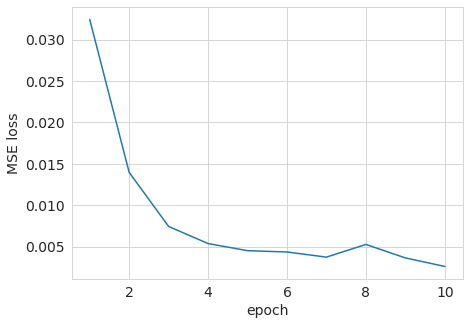

In [51]:
num_epochs = 10
losses = []
plt.rcParams.update({'font.size': 14})

for epoch in range(1, num_epochs + 1):
    autoencoder.train()
    running_loss = 0.0
    for sim_vecs, in tqdm(dataloader):
        optimizer.zero_grad()
        outputs = autoencoder(sim_vecs)
        loss = criterion(sim_vecs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sim_vecs.shape[0]
        
    losses += [running_loss / len(dataset)]
    clear_output()
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, epoch + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.show()

Take the embeddings of nodes from the bottleneck layer.

In [52]:
autoencoder.eval()
with torch.no_grad():
    ae_embeds = autoencoder.encode(distance_matrix)

In [53]:
train_ae_embeds = np.stack([ae_embeds[id_to_index[node]].numpy() for node in train_index])
test_ae_embeds = np.stack([ae_embeds[id_to_index[node]].numpy() for node in test_index])
train_ae_embeds.shape, test_ae_embeds.shape

((2031, 512), (677, 512))

Now, fit the Logistic Regression on top of these embeddings.

In [54]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(train_ae_embeds, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.1s finished


In [55]:
print('Neighborhood Autoencoder + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(train_ae_embeds)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(test_ae_embeds)):.4f}')

Neighborhood Autoencoder + Logistic Regression
Train accuracy: 0.8808
Test accuracy: 0.8198


Also try to combine Neighborhood Autoencoder embeddings with PCA compressed features.

In [56]:
na_train = np.concatenate([X_train_pca, train_ae_embeds], axis=1)
na_test = np.concatenate([X_test_pca, test_ae_embeds], axis=1)

In [57]:
log_regr = LogisticRegressionCV(
    Cs=np.logspace(-2, 2, 8), cv=3, n_jobs=-1, verbose=1, max_iter=10000
).fit(na_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.6s finished


In [58]:
print('Neighborhood Autoencoder + PCA features + Logistic Regression')
print(f'Train accuracy: {accuracy_score(y_train, log_regr.predict(na_train)):.4f}')
print(f'Test accuracy: {accuracy_score(y_test, log_regr.predict(na_test)):.4f}')

Neighborhood Autoencoder + PCA features + Logistic Regression
Train accuracy: 0.9473
Test accuracy: 0.8242
